# GalaxyZoo HIT

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from utils import calc_session_boundaries, expand_session

In [3]:
! curl -s -d /dev/null https://docs.google.com/spreadsheets/d/140n_GZ7nNHhwcG_eIUThxBKiIBoZLxFV7wKMwoUsVIw/export?exportFormat=csv > Data_for_Student_Hiring_Project-Citizen_Science-ngzLast100K1.csv

dataframe = pd.read_csv('Data_for_Student_Hiring_Project-Citizen_Science-ngzLast100K.csv',
                        header=None,
                        names=['id', 'stamp'])

In [4]:
print(f'There are {len(dataframe.id.unique())} unique id\'s')
print(f'There are {len(dataframe.stamp.unique())} unique time stamp\'s')

dataframe.head()

time_stamp = pd.to_datetime(dataframe['stamp'])
dataframe.drop('stamp', axis=1, inplace=True)
dataframe['stamp'] = time_stamp

print(f'The total recorded time is {dataframe.stamp.max() - dataframe.stamp.min()}.')

There are 943 unique id's
There are 13370 unique time stamp's
The total recorded time is 13 days 00:40:00.


### How many time stamps per id?

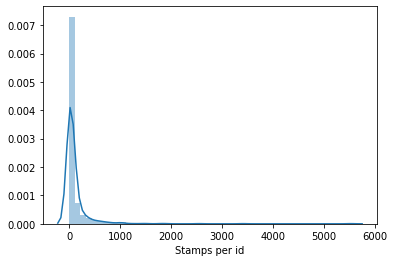

In [7]:
num_entries = dataframe.groupby('id').count()
num_entries.describe()
sns.distplot(num_entries, axlabel='Stamps per id')

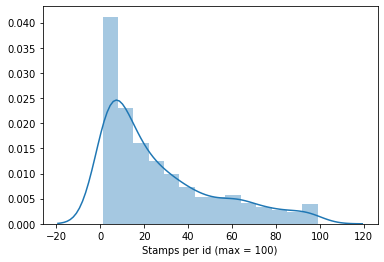

In [8]:
sns.distplot(num_entries[num_entries['stamp'] < 100], axlabel='Stamps per id (max = 100)')

## Building train/test split

Removing ids that show up only once in the dataset

In [9]:
keep_entries = num_entries[num_entries.duplicated(subset=['stamp'], keep=False)]

prediction_window = pd.Timedelta(minutes=5)
max_session_gap = pd.Timedelta(minutes=30)

Step size:

In [10]:
t = dataframe.stamp.unique()
t.sort()
step_size = pd.Timedelta(min(t[1:] - t[0:-1]))
print(f'The step size is: {step_size}\n')

The step size is: 0 days 00:01:00



Here I add a disengage column that indicates if the user will disengage after the given HIT
There are several contributions in the same minute. So I count those contributions.
I also add 0 counts to minutes with no contributions within the same session.
I use the concept of a session to avoid adding unnecessary empty lines.

In [11]:
dataframe['session'] = 0

dataframe.groupby('id').apply(lambda x: calc_session_boundaries(x, dataframe, max_session_gap))
dataframe = dataframe.groupby(['id', 'session']).apply(lambda x: expand_session(x, prediction_window, step_size))

Longest Session:

In [12]:
longest_session = int(dataframe.reset_index(drop=True).groupby(['id', 'session'])['id', 'session'].count().
                      reset_index(drop=True).groupby('session').max().max()[0])

print(f'The longest recorded session had {longest_session * step_size}')

The longest recorded session had 0 days 03:36:00


I stratified the sampling using the counting of time stamps per ID in order to ensure that train and test would have the same HIT distribution.
I also set a fixed random state in order to keep results and comparisons consistent.

In [13]:
train_ids, test_ids = [pd.DataFrame(d) for d in
                       train_test_split(keep_entries.index, stratify=keep_entries['stamp'], test_size=0.25,
                                        random_state=42)]
train_df = dataframe[dataframe['id'].isin(train_ids['id'])]
test_df = dataframe[dataframe['id'].isin(test_ids['id'])]

Sanity check:

In [14]:
print(f'The test dataset vs the total dataset ratio is {len(test_df) / (len(test_df) + len(train_df)):4.2f}.')
longest_train_session = int(train_df.reset_index(drop=True).groupby(['id', 'session'])['id', 'session'].count().
                            reset_index(drop=True).groupby('session').max().max()[0])
longest_test_session = int(test_df.reset_index(drop=True).groupby(['id', 'session'])['id', 'session'].count().
                           reset_index(drop=True).groupby('session').max().max()[0])

assert (longest_session == max(longest_test_session, longest_train_session)), 'Longest sessions do not match'

The test dataset vs the total dataset ratio is 0.22.


## Store the resulting data sets as CSV files

In [ ]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print('Done')